In [28]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal, normaltest
import scipy
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [29]:
df = pd.read_csv(r'data\AB_Test_Results.csv')
df.sample(5)

,USER_ID,VARIANT_NAME,REVENUE
9639,283,control,0.00000
1875,3044,control,0.00000
429,9732,control,0.00000
5275,6697,variant,0.00000
8667,4119,control,0.00000


In [30]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70,'-'))
    print(f'Rows: {dataframe.shape[0]}')
    print(f'Columns: {dataframe.shape[1]}')
    print(" TYPES ".center(70,'-'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'-'))
    print(dataframe.head(head))
    print(" TAIL ".center(70,'-'))
    print(dataframe.tail(head))
    print(" MISSING VALUES ".center(70,'-'))
    print(dataframe.isnull().sum())
    print(" DUPLICATED VALUES ".center(70,'-'))
    print(dataframe.duplicated().sum())
    print(" DESCRIBE ".center(70,'-'))
    print(dataframe.describe([0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1]).T)

check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 10000
Columns: 3
------------------------------- TYPES --------------------------------
USER_ID           int64
VARIANT_NAME     object
REVENUE         float64
dtype: object
-------------------------------- HEAD --------------------------------
   USER_ID VARIANT_NAME  REVENUE
0      737      variant  0.00000
1     2423      control  0.00000
2     9411      control  0.00000
3     7311      control  0.00000
4     6174      variant  0.00000
-------------------------------- TAIL --------------------------------
      USER_ID VARIANT_NAME  REVENUE
9995     1981      control  0.00000
9996      502      variant  0.00000
9997     9214      variant  0.00000
9998     7741      control  0.00000
9999     9468      control  0.00000
--------------------------- MISSING VALUES ---------------------------
USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64
------------------------- DUPLICATED VALUES -----------

In [31]:
data_size= df.shape[0]

In [32]:
duplicates = df.groupby("USER_ID")["VARIANT_NAME"].nunique() > 1
duplicates = duplicates[duplicates].index
df = df[~df["USER_ID"].isin(duplicates)]
(data_size-df.shape[0])/data_size

0.393

In [8]:
df.sort_values(by='REVENUE', ascending=False).head(10)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01000
8168,2166,control,29.32000
2482,7356,variant,23.04000
6412,1053,control,20.07000
5217,3684,variant,19.47000
5530,282,control,18.56000
758,4445,control,17.05000
4031,2059,control,14.24000
9019,1973,control,14.07000
4561,4966,variant,12.99000


In [9]:
print(" DESCRIBE ".center(70,'-'))

df.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["REVENUE"]].T

------------------------------ DESCRIBE ------------------------------


,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
REVENUE,6070.00000,0.10706,2.67350,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.16000,196.01000


(0.0, 205.80949999999999)

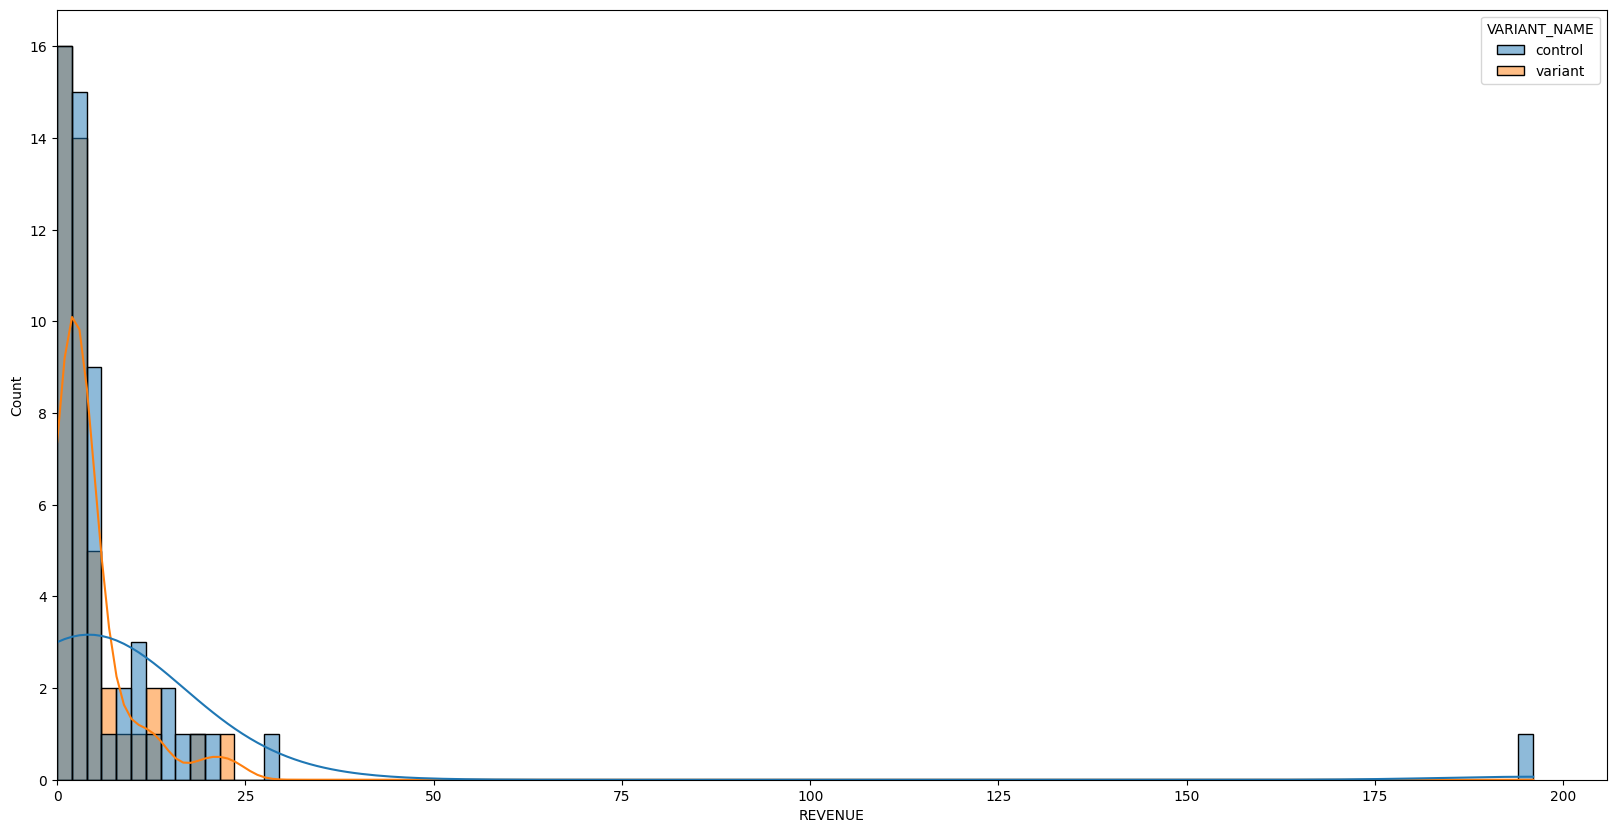

In [54]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

sns.histplot(
    data=df_old.loc[df["REVENUE"] !=0],
    x="REVENUE",
    ax=ax,
    bins=100,
    kde=True,
    hue="VARIANT_NAME"
)

ax.set_xlim(0)


In [37]:
import statsmodels.stats.api as sms
df_old = df.copy()
# What is the confidence interval for the 'REVENUE' value?
confidence_interval_1 = sms.DescrStatsW(df_old["REVENUE"]).tconfint_mean()
confidence_interval_1

(0.039794372950474055, 0.17433412787324915)

In [38]:
# Gormek istemedigimiz aykiri degerleri daha sonraki islemler icin temizleyelim

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit.round(), up_limit.round()


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

replace_with_thresholds(df, "REVENUE")

In [39]:
confidence_interval_2 = sms.DescrStatsW(df["REVENUE"]).tconfint_mean()
confidence_interval_2[1]

0.05730476029716155

In [45]:
def difference(x:float,y:float):
    val = x-y
    perc = val/x
    return f'{round(perc,2)*100} %'
difference(
    x=confidence_interval_1[1],
    y=confidence_interval_2[1]
)



'67.0 %'

<Axes: xlabel='VARIANT_NAME', ylabel='REVENUE'>

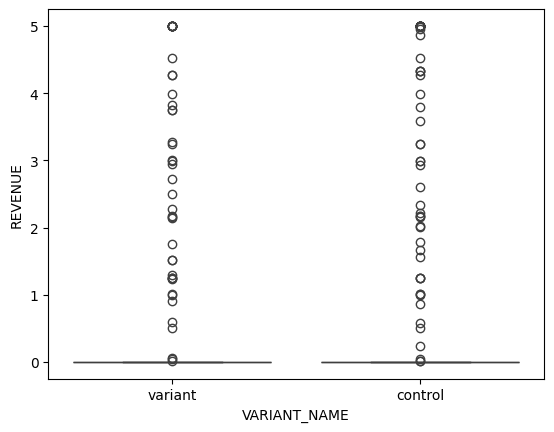

In [49]:
sns.boxplot(data=df, x='VARIANT_NAME', y='REVENUE')

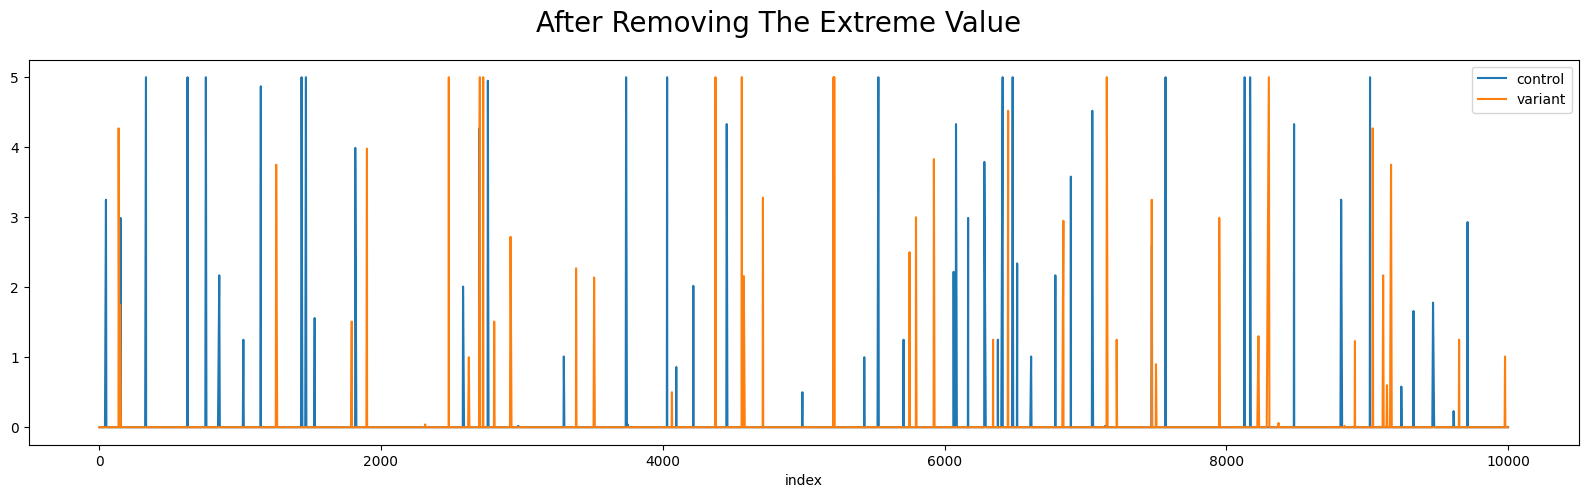

In [50]:
df[df['VARIANT_NAME'] == "control"].reset_index().set_index("index")['REVENUE'].plot(legend = True, label = "control", figsize = (20,5))
df[df['VARIANT_NAME'] == "variant"].reset_index().set_index("index")['REVENUE'].plot(legend = True, label = "variant")
plt.suptitle("After Removing The Extreme Value", fontsize = 20);

In [51]:
df.groupby('VARIANT_NAME').agg({'REVENUE': ['sum', 'count']}).reset_index()

VARIANT_NAME   REVENUE      
                     sum count
0      control 165.06000  3026
1      variant 117.98000  3044

In [56]:
all_stat = df.groupby(
    by='VARIANT_NAME') \
        .agg({
            'USER_ID': 'nunique',
            'REVENUE': ['sum', 'mean', 'median', 'count','std']})
all_stat

USER_ID   REVENUE                              
             nunique       sum    mean  median count     std
VARIANT_NAME                                                
control         2390 165.06000 0.05455 0.00000  3026 0.46584
variant         2393 117.98000 0.03876 0.00000  3044 0.37836